<a id = Section1></a>
# **1. Introduction**

The Home Mortgage Disclosure Act (HMDA) requires many **financial institutions** to **maintain, report, and publicly disclose loan-level information** about **mortgages**. These **data help** show whether **lenders** are **serving** the **housing needs** of their communities; they **give** public officials **information** that **helps** them **make decisions and policies**; and they shed light on lending patterns that could be discriminatory. The **public data** are **modified** to **protect** applicant and borrower **privacy**.

<center><img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Great_Seal_of_the_United_States_%28obverse%29.svg" width = "40%"></center>

**<center>HMDA was originally enacted by Congress in 1975 and is implemented by Regulation C.</center>**

In general, the **primary purposes** of the Home Mortgage Disclosure Act and Regulation C are to **monitor the geographic targets of mortgage lenders**, **provide** an **identification mechanism** for any predatory **lending practices**, and to **provide** reporting **statistics** on the mortgage market **to** the **government**.

The HMDA requires certain financial institutions to collect and report data on mortgage loan applications, originations, purchases, and other related activities. The data collected through LAR includes information about the loan applicant, the property, and the loan itself.

Please find the original dataset here:

Note: Instead of using the large CSV file, I will be utilizing the sampled data available in the "Sampled_loan_data" section for the following analysis. This will allow for faster processing and better resource utilization.

https://ffiec.cfpb.gov/data-publication/snapshot-national-loan-level-dataset/2022

Please find the schema/codebook here:

https://ffiec.cfpb.gov/documentation/publications/loan-level-datasets/lar-data-fields

Note that since dataset was too large, I randomly selected **30000** rows from the original csv file & saved it as a new **Sampled_loan_data.csv** file.

<a id = Section2></a>
# **2. Problem Statement**

The problem here is to **analyze and predict** the **mortgage decisions** based on the **information provided to the machine**, **empowering** the **government** to take **rational decisions** about providing the **lending information** of the **borrower**.
<center><img src = "https://ocdn.eu/images/pulscms/NWQ7MDA_/cfe27a08-f80b-480f-b5bd-7914252c912b.jpeg"></center>

<br>

The **target feature** in the acquired data set is **action_taken** on the application of the applicant.<br>

|Target Feature|Potential Values|
| :-- | :-- |
|**action_taken**|1. Loan originated|
||2. Application approved but not accepted| 
||3. Application denied|
||4. Application withdrawn by applicant|
||5. File closed for incompleteness|
||6. Purchased loan|
||7. Preapproval request denied|
||8. Preapproval request approved but not accepted|


<a id = Section3></a>
# **3. Importing Libraries**

### **Importing Libraries**

In [15]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import random
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.impute import SimpleImputer
from scipy import stats
from random import randint


#evaluation metrics and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, silhouette_score
from sklearn import cluster, covariance, manifold

### **PLEASE DO NOT EXECUTE BELOW CODE**


Please note that the code below utilizes a zipfile downloaded from the website (https://ffiec.cfpb.gov/data-publication/snapshot-national-loan-level-dataset/2022) for the year 2022. It randomly selects 30,000 rows from the dataset since the file is too large to be loaded in Google Colab.

**Note: Each time the code is executed, it will generate a different random sample.**

For instructors' convenience, they can download the sampled dataset from https://github.com/YanHuang1994/House-loan-prediction

In the Sampled_data section, the code will work with the pre-saved CSV file to continue the analysis.

This approach ensures that instructors can run the code without having to download the large zipfile and obtain consistent results with the pre-saved CSV file.


<a id = Section4></a>
# **4. Data Acquisition & Description**

This **dataset covers** all **mortgage decisions** made in **2022** . Data for additional states and years can be accessed <a href = "https://ffiec.cfpb.gov/data-publication/snapshot-national-loan-level-dataset/2022">here</a>. This dataset was **compiled by the Consumer Finance Protection Board** (CFPB) and we performed a little amount of modification.

| Records | Features | Dataset Size |
| :-- | :-- | :-- |
| 1million  |  99 | 5.6 GB|

| Id | Features | Description |
| :--| :--| :--|
|1|**action_taken**|Action taken on file. Contains: [Loan originated, Application approved but not accepted, Application denied by financial institution,|
||| Application withdrawn by applicant, File closed for incompleteness, Loan purchased by the institution

In [2]:
## instructor doesnot need to run this code and can move to sampled data section instead

import zipfile

zip_path = './2022_public_lar_csv.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

In [3]:
# Load the 30k rows to sample from the original CSV file
file_path = './2022_public_lar_csv.csv'
total_rows = sum(1 for _ in open(file_path)) - 1  # Get the total number of rows excluding the header

nrows = 30000
skiprows = sorted(random.sample(range(1, total_rows + 1), total_rows - nrows))  # Randomly select rows to skip

df = pd.read_csv(file_path, skiprows=skiprows)

df.head(5)

,activity_year,lei,derived_msa_md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason_2,denial_reason_3,denial_reason_4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2022,RVDPPPGHCGZ40J4VQ731,40140,CA,6065.0,6.065043e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,2855,52.19,87400,60.0,688,1398,51
1,2022,RVDPPPGHCGZ40J4VQ731,43420,AZ,4003.0,4.003002e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Joint,...,NaN,NaN,NaN,5280,46.27,64500,125.0,1129,1660,40
2,2022,RVDPPPGHCGZ40J4VQ731,38060,AZ,4013.0,4.013117e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,NaN,NaN,NaN,5194,74.70,88800,95.0,1353,1686,18
3,2022,RVDPPPGHCGZ40J4VQ731,48864,DE,10003.0,1.000301e+10,C,VA:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4637,49.43,103900,89.0,1301,1851,68
4,2022,RVDPPPGHCGZ40J4VQ731,99999,PA,42105.0,4.210595e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,2240,2.90,72900,80.0,673,1128,56


In [4]:
# Save the sampled data as a new CSV file so that each time you load random 30k rows, you do not end up with a new dataset
sampled_file_path = './Sampled_loan_data.csv'  # i saved the sampled data here
sample_loan_lar=df.to_csv(sampled_file_path, index=False)

print("Sampled data saved successfully.")

Sampled data saved successfully.


In [9]:
file_path_1='./Sampled_loan_data.csv'
data=pd.read_csv(file_path_1)
data.head(10)

,activity_year,lei,derived_msa_md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason_2,denial_reason_3,denial_reason_4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2022,RVDPPPGHCGZ40J4VQ731,40140,CA,6065.0,6.065043e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,2855,52.19,87400,60.0,688,1398,51
1,2022,RVDPPPGHCGZ40J4VQ731,43420,AZ,4003.0,4.003002e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Joint,...,NaN,NaN,NaN,5280,46.27,64500,125.0,1129,1660,40
2,2022,RVDPPPGHCGZ40J4VQ731,38060,AZ,4013.0,4.013117e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,NaN,NaN,NaN,5194,74.70,88800,95.0,1353,1686,18
3,2022,RVDPPPGHCGZ40J4VQ731,48864,DE,10003.0,1.000301e+10,C,VA:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4637,49.43,103900,89.0,1301,1851,68
4,2022,RVDPPPGHCGZ40J4VQ731,99999,PA,42105.0,4.210595e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,2240,2.90,72900,80.0,673,1128,56
5,2022,RVDPPPGHCGZ40J4VQ731,99999,TX,48031.0,4.803195e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3631,25.23,68800,107.0,1065,1632,23
6,2022,RVDPPPGHCGZ40J4VQ731,12420,TX,48453.0,4.845300e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,NaN,NaN,NaN,4182,88.16,110300,61.0,482,674,17
7,2022,RVDPPPGHCGZ40J4VQ731,21340,TX,48141.0,4.814100e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,NaN,NaN,NaN,5785,97.75,59400,76.0,1092,1793,35
8,2022,RVDPPPGHCGZ40J4VQ731,19124,TX,48121.0,4.812102e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4424,59.67,97400,112.0,1204,1534,35
9,2022,RVDPPPGHCGZ40J4VQ731,21780,KY,21101.0,2.110102e+10,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3298,9.88,83700,73.0,625,1135,44


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 99 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   activity_year                             30000 non-null  int64  
 1   lei                                       30000 non-null  object 
 2   derived_msa_md                            30000 non-null  int64  
 3   state_code                                29681 non-null  object 
 4   county_code                               29454 non-null  float64
 5   census_tract                              29374 non-null  float64
 6   conforming_loan_limit                     29877 non-null  object 
 7   derived_loan_product_type                 30000 non-null  object 
 8   derived_dwelling_category                 30000 non-null  object 
 9   derived_ethnicity                         30000 non-null  object 
 10  derived_race                      

### **Numerical Data Distribution**

- We shall plot all **numerical features to analyze the distribution** of their past. 
- A list of numerical **attributes** can be **obtained** by simple exectuion of **loop over data** as presented below.

In [11]:
# Extracting Numerical Features
num_list = []
for i in data.columns.values:
  if ((data[i].dtype == int) | (data[i].dtype == float) ):
    num_list.append(i)
print('Total Length:', len(num_list))    
print(num_list)

Total Length: 31
['county_code', 'census_tract', 'income', 'applicant_ethnicity_1', 'applicant_ethnicity_2', 'applicant_ethnicity_3', 'applicant_ethnicity_4', 'applicant_ethnicity_5', 'co_applicant_ethnicity_1', 'co_applicant_ethnicity_2', 'co_applicant_ethnicity_3', 'co_applicant_ethnicity_4', 'co_applicant_ethnicity_5', 'applicant_race_1', 'applicant_race_2', 'applicant_race_3', 'applicant_race_4', 'applicant_race_5', 'co_applicant_race_2', 'co_applicant_race_3', 'co_applicant_race_4', 'co_applicant_race_5', 'aus_2', 'aus_3', 'aus_4', 'aus_5', 'denial_reason_2', 'denial_reason_3', 'denial_reason_4', 'tract_minority_population_percent', 'tract_to_msa_income_percentage']


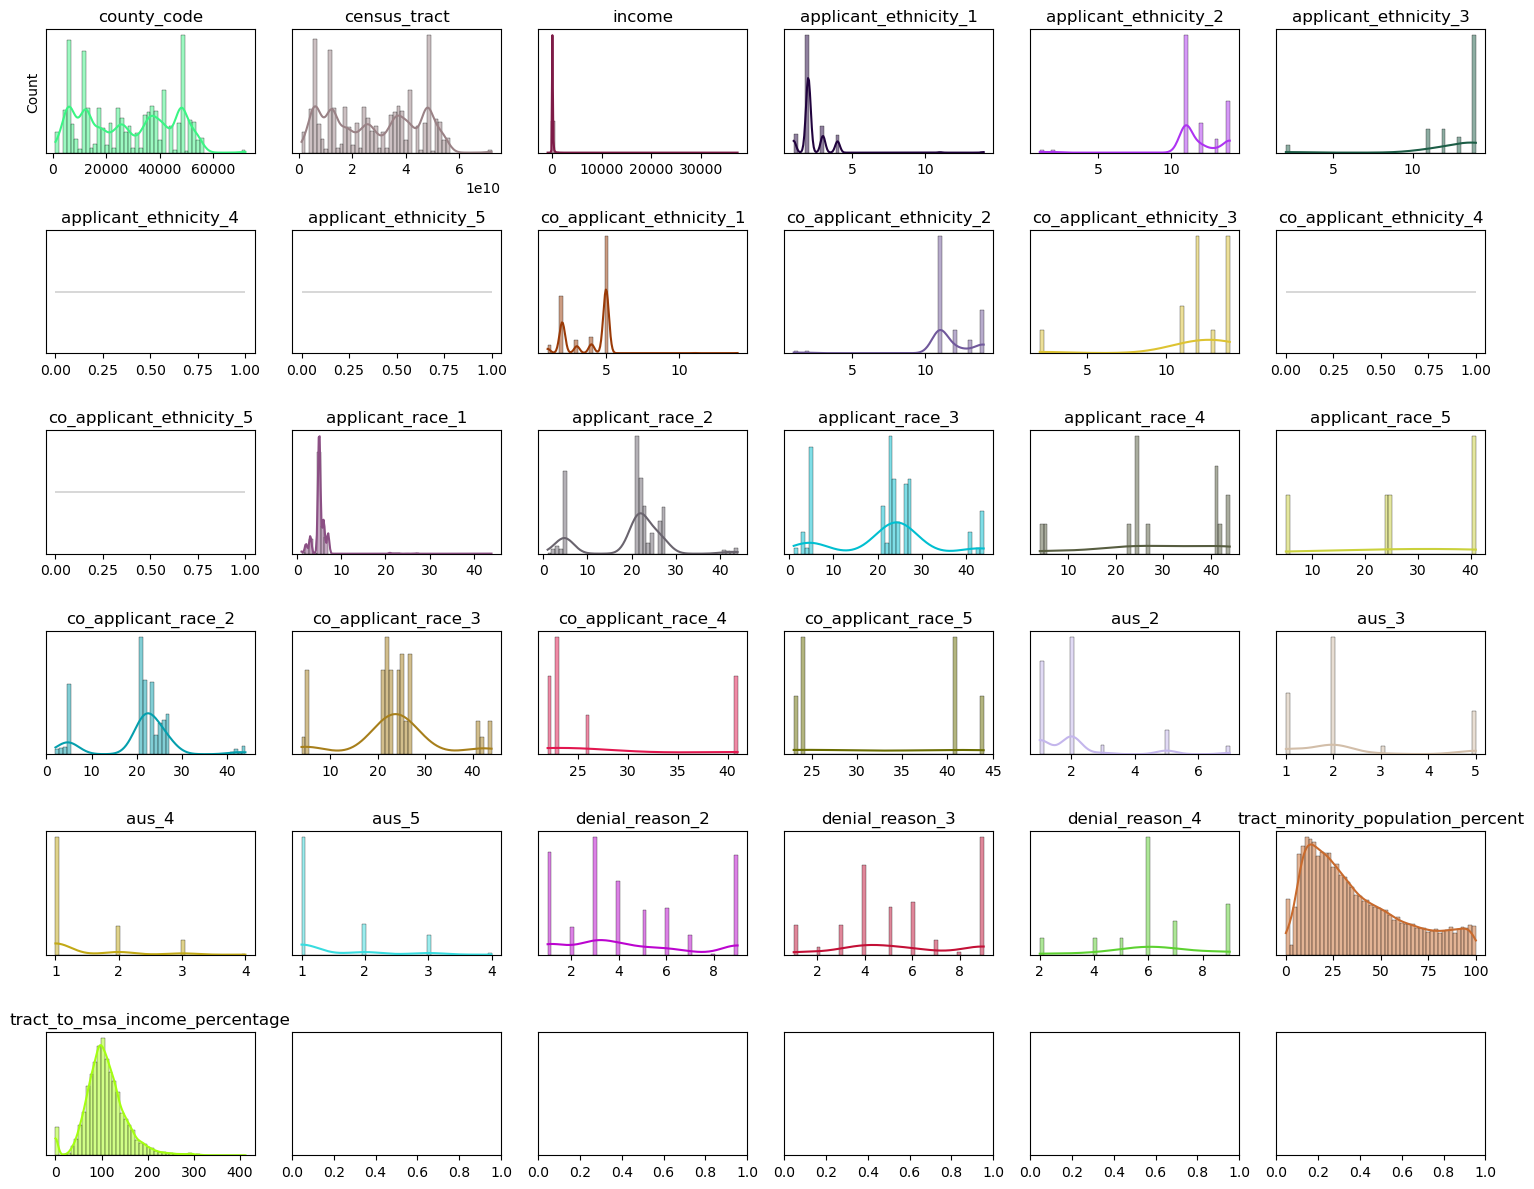

In [17]:
fig, axes = plt.subplots(nrows=6, ncols=6, sharex=False, figsize=(15, 12))

# Generating random colors
colors = ['#%06X' % randint(0, 0xFFFFFF) for _ in range(len(num_list))]

for ax, col, color in zip(axes.flat, num_list, colors):
    sns.histplot(data=data[col], bins=50, ax=ax, color=color, kde=True)
    ax.set_title(col)
    plt.setp(axes, yticks=[], xlabel='')
    ax.grid(False)

plt.tight_layout()

In [26]:
numeric_features = data[num_list]
skewed_features = numeric_features.skew()
positively_skewed_features = skewed_features[skewed_features > 0].index.tolist()
print("Positively Skewed Features:", positively_skewed_features)

number_of_positively_skewed_features = len(positively_skewed_features)
number_of_positively_skewed_features

Positively Skewed Features: ['county_code', 'census_tract', 'income', 'applicant_ethnicity_1', 'co_applicant_ethnicity_1', 'applicant_race_1', 'co_applicant_race_4', 'co_applicant_race_5', 'aus_2', 'aus_3', 'aus_4', 'aus_5', 'denial_reason_2', 'tract_minority_population_percent', 'tract_to_msa_income_percentage']


15

**Skewed**

- **Postively Skewed Features**
  - county_code,
  - census_tract,
  - income,
  - applicant_ethnicity_1,
  - co_applicant_ethnicity_1,
  - applicant_race_1,
  - co_applicant_race_4,
  - co_applicant_race_5,
  - aus_2,
  - aus_3,
  - aus_4,
  - aus_5,
  - denial_reason_2,
  - aus_5,
  - denial_reason_2,
  - tract_minority_population_percent,
  - tract_to_msa_income_percentage
- **Negatively Skewed Features**
  - NA

### **Categorical Data Distribution**

We shall plot all **categorical features to analyze the distribution** of the past data.
- But we need to find out the **length of features**. If the **length** of the features is considerably **high** we need to **skip** those **features** while analyzing categorical data distribution.
- Below we have **performed** an **iteration** over columns to find **categorical** **features**.

In [27]:
cat_features = []
for i in data.columns.values:
  if (data[i].dtype == object):
    cat_features.append(i)
print('Total Length:', len(cat_features))
print(cat_features)

Total Length: 27
['lei', 'state_code', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category', 'derived_ethnicity', 'derived_race', 'derived_sex', 'combined_loan_to_value_ratio', 'interest_rate', 'rate_spread', 'total_loan_costs', 'total_points_and_fees', 'origination_charges', 'discount_points', 'lender_credits', 'loan_term', 'prepayment_penalty_term', 'intro_rate_period', 'property_value', 'total_units', 'multifamily_affordable_units', 'debt_to_income_ratio', 'applicant_age', 'co_applicant_age', 'applicant_age_above_62', 'co_applicant_age_above_62']


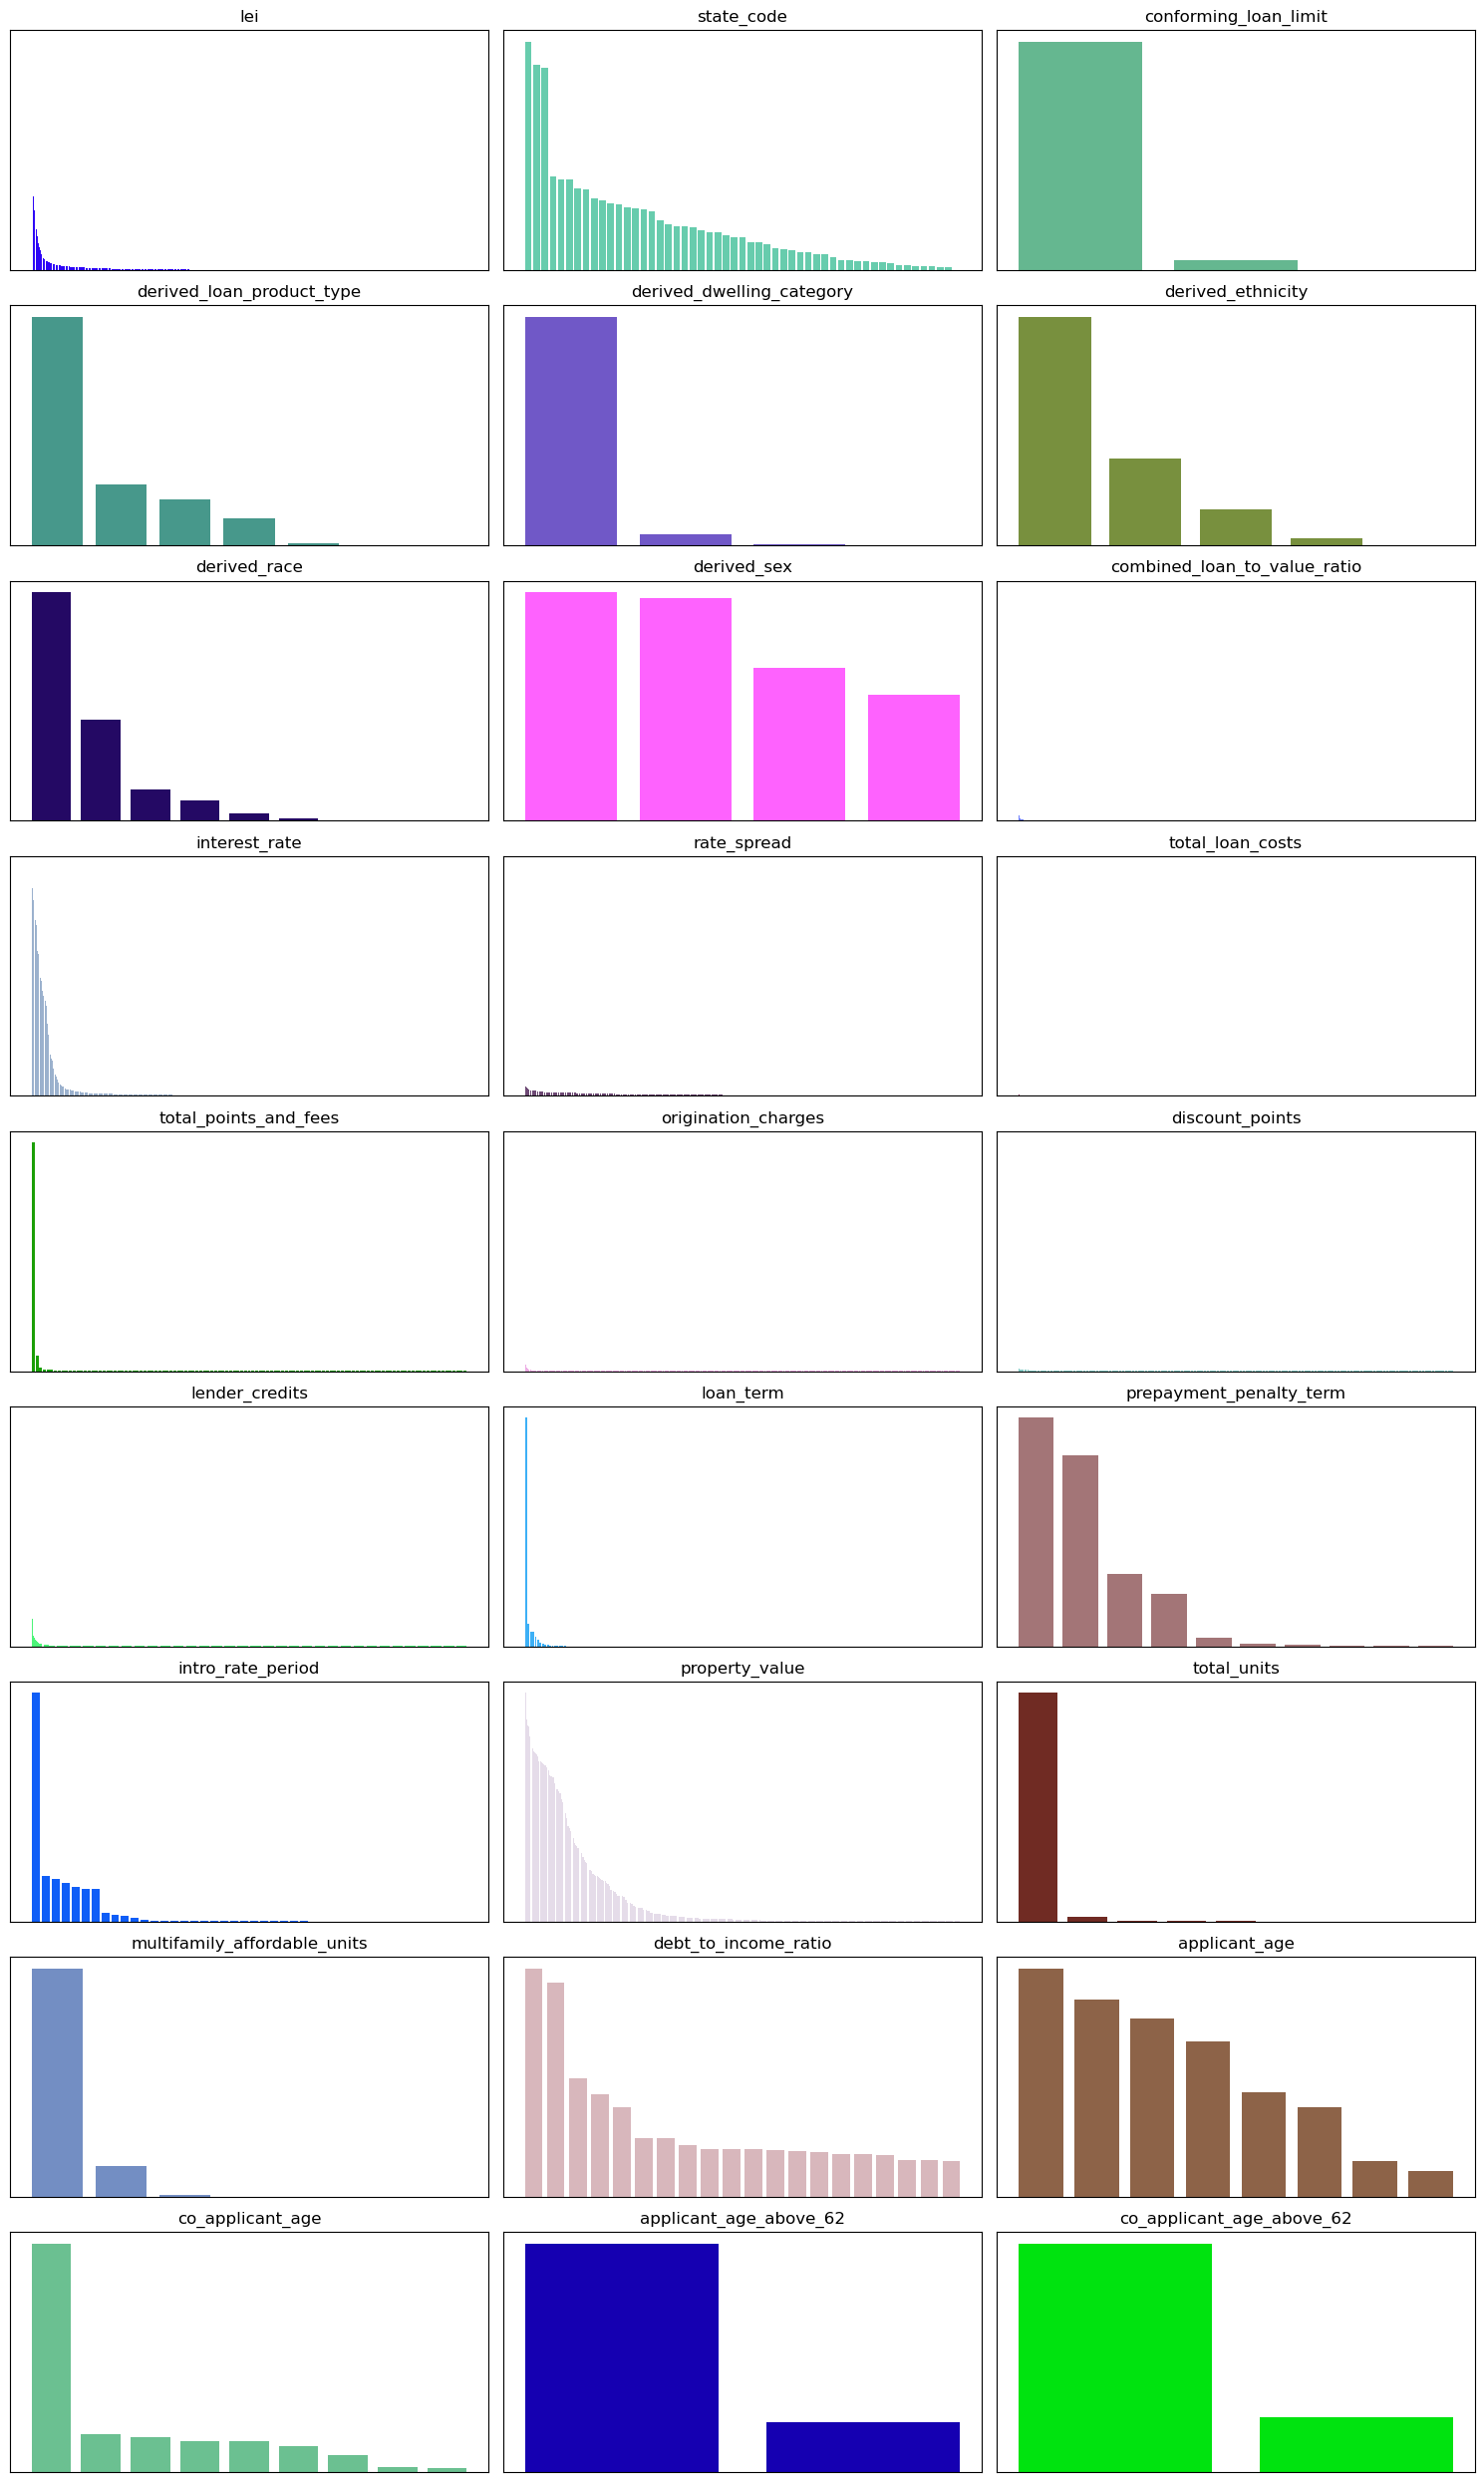

In [28]:
fig, axes = plt.subplots(nrows = 9, ncols = 3, sharex = False, figsize = (15, 25))

# Generating random colors
colors = []
for i in range(len(cat_features)):
  colors.append('#%06X' % randint(0, 0xFFFFFF))

for ax, col, color in zip(axes.flat, cat_features, colors):
  ax.bar(x = data[col].value_counts().index, height = data[col].value_counts(), color = color)
  ax.set_title(col)
  plt.setp(axes, yticks = [], xticks = [])
  ax.grid(False)
  plt.tight_layout(pad = 1.08)
plt.show()